# Исследование методов оптимизации (подбора оптимальных) параметров встраивания ЦВЗ (Цифровой водяной знак, DWM - Digital watermark)
### Так как использование нейронных сетей для Решения подобной задачи будет слишком ресурсоемким, принято решение использовать более классические методы оптимизации, такие как методы случайного поиска: метод покоординатного спуска (Гаусса-Зейделя) обучения с учителем с постоянным и уменьшающимся шагами (поочередно для каждой оси, постоянным изменением осей и выбором лучшего направления); градиентные методы: метод наискорейшего спуска, метод градиентного спуска с постоянныи и уменьшающимся шагами.

In [25]:
import random
import math
from matplotlib import pyplot as plt 
import numpy as np

In [26]:
def draw(x1_hist, x2_hist, x3_hist, x1, x2, x3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(x1_hist, x2_hist, x3_hist, 'b')
    ax.set_xlabel('freq_b')
    ax.set_ylabel('freq_t')
    ax.set_zlabel('duration')
    
    ax.scatter(x1, x2, x3, c='red')
    return plt.show()

### Метод покоординатного спуска (Гаусса-Зейделя) с постоянным шагом поочередно для каждой оси

In [63]:
class ParamsOptimizer:
    def __init__(self):
        self.x1 = 0
        self.x2 = 0
        self.x3 = 0
        self.class_list = ["music"]
        self.class_params = {el: {"freq_b": [1750,], "freq_t": [8500,], "dur": [20,], "reward": [2,], "freq_b_step": 100, "freq_t_step": 100, "dur_step": 10, "direction": 1, "param_n": 0} for el in self.class_list} 

    def make_step(self, sound_type, new_reward):
        params = self.class_params[sound_type]

        grad = -(new_reward - params["reward"][-1])
        params["reward"].append(new_reward)

        grad_sign = 1 if grad > 0 else -1
        if grad_sign == -1:
            params["direction"] = -params["direction"]
        
        if params["param_n"] % 3 == 0:
            params["freq_b"].append(params["freq_b"][-1] + params["direction"] * params["freq_b_step"])
            params["freq_t"].append(params["freq_t"][-1])
            params["dur"].append(params["dur"][-1])
        if params["param_n"] % 3 == 1:
            params["freq_t"].append(params["freq_t"][-1] + params["direction"] * params["freq_t_step"])
            params["freq_b"].append(params["freq_b"][-1])
            params["dur"].append(params["dur"][-1])
        if params["param_n"] % 3 == 2:
            params["dur"].append(params["dur"][-1] + params["direction"] * params["dur_step"])
            params["freq_b"].append(params["freq_b"][-1])
            params["freq_t"].append(params["freq_t"][-1])

    def analyze(self, sound_type, reward=None):
        params = self.class_params[sound_type]

        reward = reward or math.sqrt((params["freq_b"][-1]-self.x1)**2+(params["freq_t"][-1]-self.x2)**2+(params["dur"][-1]-self.x3)**2) # целевая функция потерь(награды)

        self.make_step(sound_type, reward)
        return reward

Метод с точным значением целевых параметров:


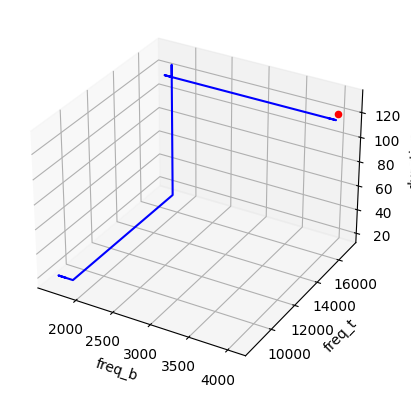

Метод с меняющимся значением целевых параметров:


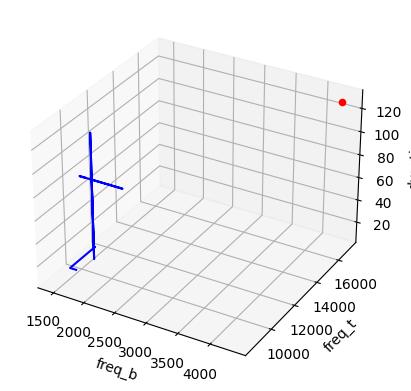

In [64]:
optimizer = ParamsOptimizer()
for i in range(200):
    optimizer.analyze("music")
    if i % 80 == 2:
        optimizer.class_params["music"]["param_n"] = optimizer.class_params["music"]["param_n"] + 1
    optimizer.x1 = 4000
    optimizer.x2 = 17000
    optimizer.x3 = 120
print("Метод с точным значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:300], optimizer.class_params["music"]["freq_t"][:300], optimizer.class_params["music"]["dur"][:300], optimizer.x1, optimizer.x2, optimizer.x3)

del optimizer

optimizer = ParamsOptimizer()
for i in range(200):
    optimizer.analyze("music")
    if i % 80 == 2:
        optimizer.class_params["music"]["param_n"] = optimizer.class_params["music"]["param_n"] + 1
    optimizer.x1 = 4000 + random.random()*500
    optimizer.x2 = 17000 + random.random()*1000
    optimizer.x3 = 120 + random.random()*10
print("Метод с меняющимся значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:300], optimizer.class_params["music"]["freq_t"][:300], optimizer.class_params["music"]["dur"][:300], optimizer.x1, optimizer.x2, optimizer.x3)

#### Данный метод плох по причине медленного приближения к цели и меньшей точности, зависящих от указанного шага, который является постоянным и нечастого изменения оси изменения.
#### Меняющееся значение целевых параметров делает работу метода невозможной

### Метод покоординатного спуска (Гаусса-Зейделя) с дробящимся шагом поочередно для каждой оси

In [65]:
class ParamsOptimizer:
    def __init__(self):
        self.x1 = 0
        self.x2 = 0
        self.x3 = 0
        self.class_list = ["music"]
        self.class_params = {el: {"freq_b": [1750,], "freq_t": [8500,], "dur": [20,], "reward": [2,], "freq_b_step": 512, "freq_t_step": 512, "dur_step": 100, "direction": 1, "param_n": 0} for el in self.class_list} 

    def make_step(self, sound_type, new_reward):
        params = self.class_params[sound_type]

        grad = -(new_reward - params["reward"][-1])
        params["reward"].append(new_reward)

        grad_sign = 1 if grad > 0 else -1
        if grad_sign == -1:
            params["direction"] = -params["direction"]
            if params["param_n"] % 3 == 0:
                params["freq_b_step"] /= 2
            if params["param_n"] % 3 == 1:
                params["freq_t_step"] /= 2
            if params["param_n"] % 3 == 2:
                params["dur_step"] /= 2
        
        if params["param_n"] % 3 == 0:
            params["freq_b"].append(params["freq_b"][-1] + params["direction"] * params["freq_b_step"])
            params["freq_t"].append(params["freq_t"][-1])
            params["dur"].append(params["dur"][-1])
        if params["param_n"] % 3 == 1:
            params["freq_t"].append(params["freq_t"][-1] + params["direction"] * params["freq_t_step"])
            params["freq_b"].append(params["freq_b"][-1])
            params["dur"].append(params["dur"][-1])
        if params["param_n"] % 3 == 2:
            params["dur"].append(params["dur"][-1] + params["direction"] * params["dur_step"])
            params["freq_b"].append(params["freq_b"][-1])
            params["freq_t"].append(params["freq_t"][-1])

    def analyze(self, sound_type, reward=None):
        params = self.class_params[sound_type]

        reward = reward or math.sqrt((params["freq_b"][-1]-self.x1)**2+(params["freq_t"][-1]-self.x2)**2+(params["dur"][-1]-self.x3)**2) # целевая функция потерь(награды)

        self.make_step(sound_type, reward)
        return reward

Метод с точным значением целевых параметров:


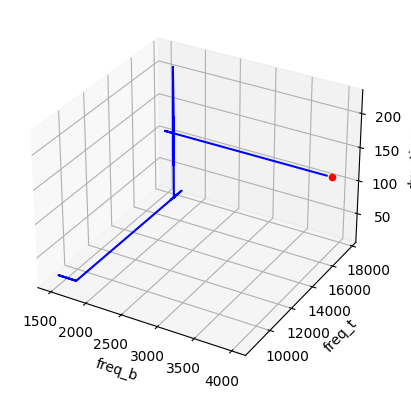

Метод с меняющимся значением целевых параметров:


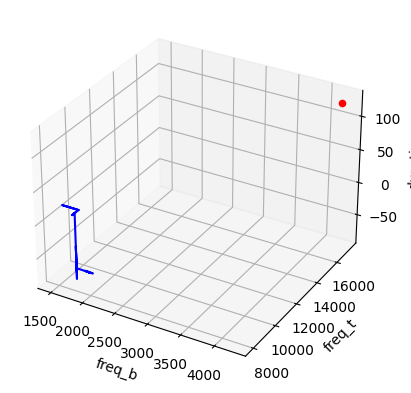

In [66]:
optimizer = ParamsOptimizer()
for i in range(120):
    optimizer.analyze("music")
    if i % 40 == 2:
        optimizer.class_params["music"]["param_n"] = optimizer.class_params["music"]["param_n"] + 1
    optimizer.x1 = 4000
    optimizer.x2 = 17000
    optimizer.x3 = 120
print("Метод с точным значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:300], optimizer.class_params["music"]["freq_t"][:300], optimizer.class_params["music"]["dur"][:300], optimizer.x1, optimizer.x2, optimizer.x3)

del optimizer

optimizer = ParamsOptimizer()
for i in range(120):
    optimizer.analyze("music")
    if i % 40 == 2:
        optimizer.class_params["music"]["param_n"] = optimizer.class_params["music"]["param_n"] + 1
    optimizer.x1 = 4000 + random.random()*500
    optimizer.x2 = 17000 + random.random()*1000
    optimizer.x3 = 120 + random.random()*10
print("Метод с меняющимся значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:300], optimizer.class_params["music"]["freq_t"][:300], optimizer.class_params["music"]["dur"][:300], optimizer.x1, optimizer.x2, optimizer.x3)

#### Данный метод более быстр в приближении к цели и более точен, т.к. начальный шаг является уменьшающимся.
#### Меняющееся значение целевых параметров делает работу метода невозможной

### Метод покоординатного спуска (Гаусса-Зейделя) с дробящимся шагом и частым изменением оси

In [71]:
class ParamsOptimizer:
    def __init__(self):
        self.x1 = 0
        self.x2 = 0
        self.x3 = 0
        self.class_list = ["music"]
        self.class_params = {el: {"freq_b": [1750,], "freq_t": [8500,], "dur": [20,], "reward": [2,], "freq_b_step": 512, "freq_t_step": 512, "dur_step": 100, "direction": 1, "param_n": 0} for el in self.class_list} 

    def make_step(self, sound_type, new_reward):
        params = self.class_params[sound_type]

        grad = -(new_reward - params["reward"][-1])
        params["reward"].append(new_reward)

        grad_sign = 1 if grad > 0 else -1
        if grad_sign == -1:
            params["direction"] = -params["direction"]
            if params["param_n"] % 3 == 0:
                params["freq_b_step"] /= 2
            if params["param_n"] % 3 == 1:
                params["freq_t_step"] /= 2
            if params["param_n"] % 3 == 2:
                params["dur_step"] /= 2
        
        if params["param_n"] % 3 == 0:
            params["freq_b"].append(params["freq_b"][-1] + params["direction"] * params["freq_b_step"])
            params["freq_t"].append(params["freq_t"][-1])
            params["dur"].append(params["dur"][-1])
        if params["param_n"] % 3 == 1:
            params["freq_t"].append(params["freq_t"][-1] + params["direction"] * params["freq_t_step"])
            params["freq_b"].append(params["freq_b"][-1])
            params["dur"].append(params["dur"][-1])
        if params["param_n"] % 3 == 2:
            params["dur"].append(params["dur"][-1] + params["direction"] * params["dur_step"])
            params["freq_b"].append(params["freq_b"][-1])
            params["freq_t"].append(params["freq_t"][-1])

    def analyze(self, sound_type, reward=None):
        params = self.class_params[sound_type]

        reward = reward or math.sqrt((params["freq_b"][-1]-self.x1)**2+(params["freq_t"][-1]-self.x2)**2+(params["dur"][-1]-self.x3)**2) # целевая функция потерь(награды)

        self.make_step(sound_type, reward)
        return reward

Метод с точным значением целевых параметров:


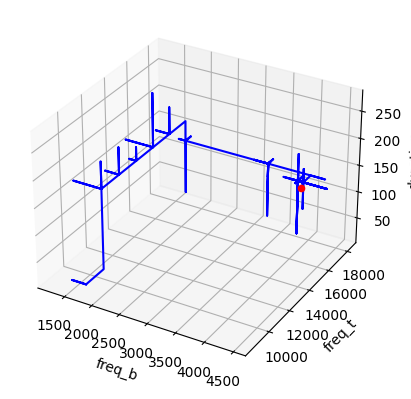

Метод с меняющимся значением целевых параметров:


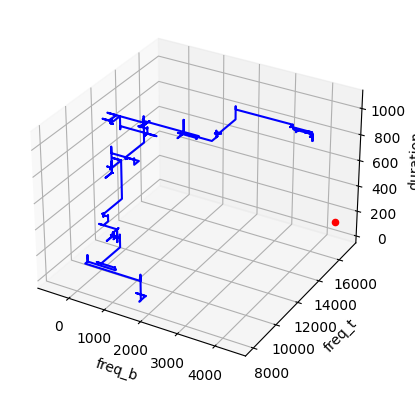

In [72]:
optimizer = ParamsOptimizer()
for i in range(150):
    optimizer.analyze("music")
    if i % 3 == 2:
        optimizer.class_params["music"]["param_n"] = optimizer.class_params["music"]["param_n"] + 1
    optimizer.x1 = 4000
    optimizer.x2 = 17000
    optimizer.x3 = 120
    if i % 27 == 2:
        optimizer.class_params["music"]["freq_b_step"] = 512
        optimizer.class_params["music"]["freq_t_step"] = 512
        optimizer.class_params["music"]["dur_step"] = 100
print("Метод с точным значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:300], optimizer.class_params["music"]["freq_t"][:300], optimizer.class_params["music"]["dur"][:300], optimizer.x1, optimizer.x2, optimizer.x3)

del optimizer

optimizer = ParamsOptimizer()
for i in range(1500):
    optimizer.analyze("music")
    if i % 3 == 2:
        optimizer.class_params["music"]["param_n"] = optimizer.class_params["music"]["param_n"] + 1
    optimizer.x1 = 4000 + random.random()*500
    optimizer.x2 = 17000 + random.random()*1000
    optimizer.x3 = 120 + random.random()*10
    if i % 27 == 2:
        optimizer.class_params["music"]["freq_b_step"] = 512
        optimizer.class_params["music"]["freq_t_step"] = 512
        optimizer.class_params["music"]["dur_step"] = 100
print("Метод с меняющимся значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:300], optimizer.class_params["music"]["freq_t"][:300], optimizer.class_params["music"]["dur"][:300], optimizer.x1, optimizer.x2, optimizer.x3)

#### Данный метод также достаточно быстр в приближении к цели и более точен, т.к. начальный шаг является уменьшающимся. Постоянное изменение изменяющихся осей позволяет постепенно прилижать каждый параметр. 
#### Меняющееся значение целевых параметров значительно увеличивает кол-во шагов для приближения к целевым значениям параметров и делает работу метода невозможной

### Метод покоординатного спуска (Гаусса-Зейделя) с дробящимся шагом и выбором лучшего направления

In [92]:
class ParamsOptimizer:
    def __init__(self):
        self.x1 = 0
        self.x2 = 0
        self.x3 = 0
        self.class_list = ["music"]
        self.class_params = {el: {"freq_b": [1750,], "freq_t": [8500,], "dur": [20,], "reward": 0, "freq_b_step": 512, "freq_t_step": 512, "dur_step": 100, "param_n": 0} for el in self.class_list} 


    def make_step(self, sound_type, new_reward):
        params = self.class_params[sound_type]

        if not params["reward"]:
            params["reward"] = new_reward
            params["freq_b"].append(params["freq_b"][-1] + params["freq_b_step"])
            return
            
        if params["param_n"] % 3 == 0:
            params["freq_b_grad"] = -(new_reward - params["reward"])
            params["freq_b"].pop()
            params["freq_t"].append(params["freq_t"][-1] + params["freq_t_step"])
        elif params["param_n"] % 3 == 1:
            params["freq_t_grad"] = -(new_reward - params["reward"])
            params["freq_t"].pop()
            params["dur"].append(params["dur"][-1] + params["dur_step"])
        elif params["param_n"] % 3 == 2:
            params["dur_grad"] = -(new_reward - params["reward"])
            params["dur"].pop()

            direction = np.argmax([params["freq_b_grad"], params["freq_t_grad"], params["dur_grad"]])

            if direction == 0:
                params["freq_b"].append(params["freq_b"][-1] + params["freq_b_step"] * np.sign(params["freq_b_grad"]))
                params["freq_t"].append(params["freq_t"][-1])
                params["dur"].append(params["dur"][-1])
                if params["freq_b_grad"] < 0:
                    params["freq_b_step"] /= 2
            elif direction == 1:
                params["freq_t"].append(params["freq_t"][-1] + params["freq_t_step"] * np.sign(params["freq_t_grad"]))
                params["freq_b"].append(params["freq_b"][-1])
                params["dur"].append(params["dur"][-1])
                if params["freq_t_grad"] < 0:
                    params["freq_t_step"] /= 2
            elif direction == 2:
                params["dur"].append(params["dur"][-1] + params["dur_step"] * np.sign(params["dur_grad"]))
                params["freq_t"].append(params["freq_t"][-1])
                params["freq_b"].append(params["freq_b"][-1])
                if params["dur_grad"] < 0:
                    params["dur_step"] /= 2
            

            params["reward"] = 0

        params["param_n"] = params["param_n"] + 1

    def analyze(self, sound_type, reward=None):
        params = self.class_params[sound_type]
        reward = reward or math.sqrt((params["freq_b"][-1]-self.x1)**2+(params["freq_t"][-1]-self.x2)**2+(params["dur"][-1]-self.x3)**2)

        self.make_step(sound_type, reward)  
        return reward
  

Метод с точным значением целевых параметров:


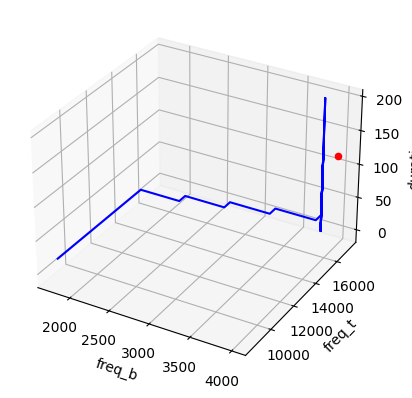

Метод с меняющимся значением целевых параметров:


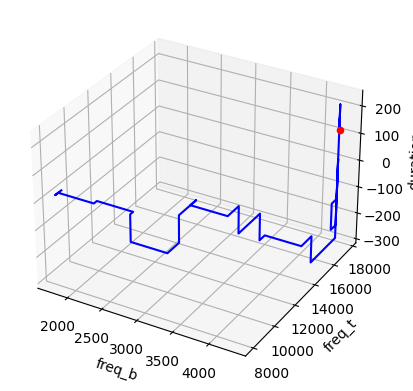

In [93]:
optimizer = ParamsOptimizer()
for i in range(212):
    optimizer.analyze("music")
    optimizer.x1 = 4000
    optimizer.x2 = 17000
    optimizer.x3 = 120
    if i % 27 == 2:
        optimizer.class_params["music"]["freq_b_step"] = 512
        optimizer.class_params["music"]["freq_t_step"] = 512
        optimizer.class_params["music"]["dur_step"] = 100
print("Метод с точным значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:64], optimizer.class_params["music"]["freq_t"][:64], optimizer.class_params["music"]["dur"][:64], optimizer.x1, optimizer.x2, optimizer.x3)

del optimizer

optimizer = ParamsOptimizer()
for i in range(212):
    optimizer.analyze("music")
    optimizer.x1 = 4000 + random.random()*500
    optimizer.x2 = 17000 + random.random()*1000
    optimizer.x3 = 120 + random.random()*10
    if i % 27 == 2:
        optimizer.class_params["music"]["freq_b_step"] = 512
        optimizer.class_params["music"]["freq_t_step"] = 512
        optimizer.class_params["music"]["dur_step"] = 100
print("Метод с меняющимся значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:64], optimizer.class_params["music"]["freq_t"][:64], optimizer.class_params["music"]["dur"][:64], optimizer.x1, optimizer.x2, optimizer.x3)

#### Данный метод также медленнее в приближении к цели, но более точен, т.к. изменяющийся параметр и его направление определяется каждые 4 шага. 
#### Меняющееся значение целевых параметров практически не влияет на кол-во шагов для приближения к целевым значениям параметров и делает работу метода пригодной.

### Метод градиентного спуска с уменьшающимся шагами

In [103]:
class ParamsOptimizer():

    x1 = 0
    x2 = 0
    x3 = 0
    class_list = ["music", "speach", "silence"]
    class_params = {el: {"freq_b": [1750,], "freq_t": [8500,], "dur": [20,], "reward": 0, "freq_b_grad": 0, "freq_t_grad": 0, "dur_grad": 0, "freq_b_step": 10000, "freq_t_step": 10000, "dur_step": 10000, "param_n": 0} for el in class_list} 
    rate = 10000
    0
    target = 1 # min -1 / max 1

    @staticmethod
    def __limit_value(value, min_value = 0, max_value = 20000):
        if value > max_value:
            return max_value
        elif value < min_value:
            return min_value
        return value


    def make_step(self, sound_type, new_reward):
        params = self.class_params[sound_type]

        if not params["reward"]:
            params["reward"] = new_reward
            params["freq_b"].append(self.__limit_value(params["freq_b"][-1] + params["freq_b_step"], max_value=params["freq_t"][-1]+1))
            return
            
        if params["param_n"] % 3 == 0:
            params["freq_b_grad"] = self.target*(new_reward - params["reward"])
            params["freq_b"].pop()
            params["freq_t"].append(self.__limit_value(params["freq_t"][-1] + params["freq_t_step"], min_value=params["freq_b"][-1]+1, max_value=20000))
        elif params["param_n"] % 3 == 1:
            params["freq_t_grad"] = self.target*(new_reward - params["reward"])
            params["freq_t"].pop()
            params["dur"].append(self.__limit_value(params["dur"][-1] + params["dur_step"], min_value=10, max_value=975))
        elif params["param_n"] % 3 == 2:
            params["dur_grad"] = self.target*(new_reward - params["reward"])
            params["dur"].pop()

            params["freq_b"].append(self.__limit_value(params["freq_b"][-1] + self.rate*params["freq_b_grad"], max_value=params["freq_t"][-1]+1))
            params["freq_t"].append(self.__limit_value(params["freq_t"][-1] + self.rate*params["freq_t_grad"], min_value=params["freq_b"][-1]+1, max_value=20000))
            params["dur"].append(self.__limit_value(params["dur"][-1] + self.rate*params["dur_grad"], min_value=10, max_value=975))

            
            if params["freq_b_grad"] < 0:
                params["freq_b_step"] /= 2
            if params["freq_t_grad"] < 0:
                params["freq_t_step"] /= 2
            if params["dur_grad"] < 0:
                params["dur_step"] /= 2


            params["reward"] = 0

        params["param_n"] = params["param_n"] + 1

    def analyze(self, sound_type, reward=None, noise=0):
        params = self.class_params[sound_type]
        reward = reward or -math.sqrt((params["freq_b"][-1]-self.x1)**2+(params["freq_t"][-1]-self.x2)**2+(params["dur"][-1]-self.x3)**2) / 28302 * 3 + random.random()*noise
        
        self.make_step(sound_type, reward)
        return reward
  


Метод с точным значением целевых параметров:


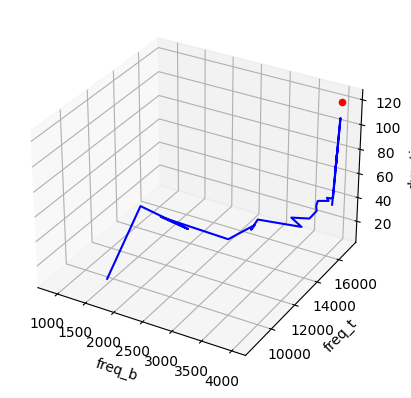

Метод с меняющимся значением целевых параметров:


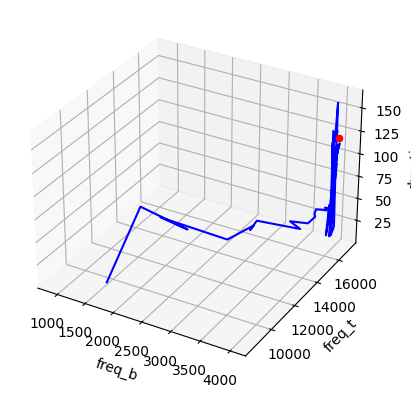

In [104]:
optimizer = ParamsOptimizer()
optimizer.x1 = 4000
optimizer.x2 = 17000
optimizer.x3 = 120

for i in range(120):
    optimizer.analyze("music")
    if i % 28 == 3 and i // 84 >= 1:
        optimizer.class_params["music"]["freq_b_step"] = 100
        optimizer.class_params["music"]["freq_t_step"] = 100
        optimizer.class_params["music"]["dur_step"] = 100
print("Метод с точным значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:64], optimizer.class_params["music"]["freq_t"][:64], optimizer.class_params["music"]["dur"][:64], optimizer.x1, optimizer.x2, optimizer.x3)

del optimizer

optimizer = ParamsOptimizer()
optimizer.x1 = 4000
optimizer.x2 = 17000
optimizer.x3 = 120

for i in range(120):
    optimizer.analyze("music", noise=0.01)
    if i % 28 == 3 and i // 84 >= 1:
        optimizer.class_params["music"]["freq_b_step"] = 100
        optimizer.class_params["music"]["freq_t_step"] = 100
        optimizer.class_params["music"]["dur_step"] = 100
print("Метод с меняющимся значением целевых параметров:")
draw(optimizer.class_params["music"]["freq_b"][:64], optimizer.class_params["music"]["freq_t"][:64], optimizer.class_params["music"]["dur"][:64], optimizer.x1, optimizer.x2, optimizer.x3)

#### Данный метод является быстрейшим в приближении к цели среди рассмотренных, а также достаточно точен и постепенно приближает каждое отдельное значение параметра. 
#### Меняющееся значение целевых параметров практически не влияет на кол-во шагов для приближения к целевым значениям параметров и делает работу метода пригодной.